# 一、介绍
# 二、关键方法
## 2.1 核密度估计方法
## 2.2 中文BERT模型
### 2.2.1 Transformer编码器概述
### 2.2.2 中文BERT的输入表示
### 2.2.3 预训练任务与目标函数
### 2.2.4 输出表示与下游应用
## 2.3 对最佳簇数监督的Kmeans聚类
### 2.3.1 BERT 词向量提取
### 2.3.2 KMeans 聚类及其熵度量
### 2.3.3 引入聚类数惩罚项
### 2.3.4 网格搜索过程
## 2.4 ANOVA
### 2.4.1 ANOVA的假设前提
### 2.4.2 组间差异与组内差异
### 2.4.3 F统计量
## 2.5 混淆矩阵与性能指标
### 2.5.1 混淆矩阵
### 2.5.2 性能指标
# 三、实验
## 3.1 反应时长与得分的分布分析
## 3.2 BERT编码—Kmeans真假词聚类模型
### 3.2.1 BERT编码器
### 3.2.2 监督簇数的Kmeans聚类
### 3.2.3 基于PCA的聚类可视化过程
## 3.3 深度判别模型训练与迁移学习
## 3.4 词频等级的影响显著性探究
### 3.4.1 ANOVA单因素显著性分析
# 四、讨论
## 4.1 人类与模型在真假词判断中的性能对比分析
## 4.2 认知与心理机制

In [57]:
import os
import pandas as pd
import re
import os
import torch
import pickle
import math
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font",family='Microsoft YaHei')
# 设置设备（GPU 优先）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ 使用设备：{device}")

✅ 使用设备：cuda


In [12]:
# 获取当前工作目录（适配 Jupyter 或交互式环境）
current_dir = os.getcwd()

# 构建 dataset 和 data_preprocessed 路径
dataset_dir = os.path.join(current_dir, 'dataset')
output_dir = os.path.join(current_dir, 'data_preprocessed')
os.makedirs(output_dir, exist_ok=True)

# 使用正则表达式匹配 "H_Data (%d).csv"
pattern = re.compile(r'H_Data \((\d+)\)\.csv')

# 获取所有符合命名规则的文件
file_list = []
for filename in os.listdir(dataset_dir):
    match = pattern.match(filename)
    if match:
        number = int(match.group(1))
        file_list.append((number, filename))
    else:
        print(filename)

# 按数字排序
file_list.sort()
# 编码尝试顺序
encodings_to_try = ['utf-8', 'gbk', 'gb2312']
# 逐个读取、保存
for number, filename in file_list:
    input_path = os.path.join(dataset_dir, filename)
    output_filename = f"{number}.csv"
    output_path = os.path.join(output_dir, output_filename)
    for enc in encodings_to_try:
        try:
            df = pd.read_csv(input_path, encoding=enc)
            df.to_csv(output_path, index=False, encoding='utf-8-sig')
            # print(f"已处理：{filename} → {output_filename}")
            break
        except Exception as e:
            continue

In [40]:
import os
import csv
from collections import defaultdict

# 当前路径和数据集路径
current_dir = os.getcwd()
dataset_dir = os.path.join(current_dir, 'data_preprocessed')
# 用于统计成功处理的文件数
processed_files = 0
# 用于存储所有词语信息的字典
# 格式：{ word: {'is_true_word': ..., 'freq_level': ..., 'guesses': [ {'player_guess': ..., 'time': ..., 'score': ...}, ... ] } }
word_data = {}

for i in range(1, 659):
    file_path = os.path.join(dataset_dir, f"{i}.csv")
    if not os.path.exists(file_path):
        continue

    with open(file_path, 'r', encoding='utf-8-sig') as f:  # 用 utf-8-sig 去除 BOM
        reader = csv.DictReader(f)  # 使用默认逗号分隔符
        for row in reader:
            word = row['Word']
            is_true_word = row['IsTrueWord']
            freq_level = int(row['FreqLevel'])
            player_guess = row['PlayerGuess']
            time_taken = float(row['TimeTaken'])
            score = float(row['Score'])

            if word not in word_data:
                word_data[word] = {
                    'is_true_word': is_true_word,
                    'freq_level': freq_level,
                    'guesses': []
                }

            word_data[word]['guesses'].append({
                'player_guess': player_guess,
                'time': time_taken,
                'score': score
            })
    processed_files += 1  # ✅ 成功读取则计数加一
# 输出统计结果
print(f"✅ 共成功处理了 {processed_files} 个 CSV 文件")
# 示例：按词语查询数据
def query_word(word):
    return word_data.get(word, "该词语未出现")

# 举例查询
example = '柯英'
print(query_word(example))


✅ 共成功处理了 658 个 CSV 文件
{'is_true_word': 'True', 'freq_level': 4, 'guesses': [{'player_guess': 'False', 'time': 2.926300000190735, 'score': -5.0}, {'player_guess': 'True', 'time': 0.7335999999046325, 'score': 7.143616000137329}, {'player_guess': 'True', 'time': 1.1525, 'score': 6.5404}, {'player_guess': 'True', 'time': 0.8145999999998603, 'score': 7.026976000000201}, {'player_guess': 'True', 'time': 1.1567999999988825, 'score': 7.917760000002011}, {'player_guess': 'True', 'time': 0.9244000000000232, 'score': 6.868863999999967}, {'player_guess': 'False', 'time': 2.039, 'score': -5.0}, {'player_guess': 'True', 'time': 0.6422000000000117, 'score': 7.275231999999984}, {'player_guess': 'True', 'time': 1.2990999999999766, 'score': 6.329296000000034}, {'player_guess': 'False', 'time': 0.3598000000000466, 'score': -5.0}, {'player_guess': 'True', 'time': 0.468, 'score': 7.52608}, {'player_guess': 'False', 'time': 0.4008000000715255, 'score': -5.0}, {'player_guess': 'False', 'time': 0.744399999998

In [14]:
# 初始化计数器
TP = FP = TN = FN = 0

# 遍历所有词语及其猜测记录
for word, info in word_data.items():
    true_label = info['is_true_word'].lower() == 'true'  # 转为布尔值

    for guess in info['guesses']:
        pred_label = guess['player_guess'].lower() == 'true'  # 玩家是否猜为真词

        if true_label and pred_label:
            TP += 1
        elif not true_label and pred_label:
            FP += 1
        elif not true_label and not pred_label:
            TN += 1
        elif true_label and not pred_label:
            FN += 1

# 输出结果
print(f"✅ 混淆矩阵统计结果：")
print(f"TP（真词猜真）: {TP}")
print(f"FP（假词猜真）: {FP}")
print(f"TN（假词猜假）: {TN}")
print(f"FN（真词猜假）: {FN}")
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall    = TP / (TP + FN) if TP + FN > 0 else 0
f1_score  = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
accuracy  = (TP + TN) / (TP + FP + TN + FN)

print(f"\n🎯 准确率 (Accuracy): {accuracy:.4f}")
print(f"🎯 精确率 (Precision): {precision:.4f}")
print(f"🎯 召回率 (Recall): {recall:.4f}")
print(f"🎯 F1 分数: {f1_score:.4f}")



✅ 混淆矩阵统计结果：
TP（真词猜真）: 18600
FP（假词猜真）: 6878
TN（假词猜假）: 15738
FN（真词猜假）: 4819

🎯 准确率 (Accuracy): 0.7459
🎯 精确率 (Precision): 0.7300
🎯 召回率 (Recall): 0.7942
🎯 F1 分数: 0.7608


In [ ]:
# 初始化：每个频率等级一个计数器字典
confusion_by_level = {
    level: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}
    for level in range(1, 6)
}

# 遍历所有词
for word, info in word_data.items():
    true_label = info['is_true_word'].lower() == 'true'
    freq_level = info['freq_level']

    for guess in info['guesses']:
        pred_label = guess['player_guess'].lower() == 'true'

        if true_label and pred_label:
            confusion_by_level[freq_level]['TP'] += 1
        elif not true_label and pred_label:
            confusion_by_level[freq_level]['FP'] += 1
        elif not true_label and not pred_label:
            confusion_by_level[freq_level]['TN'] += 1
        elif true_label and not pred_label:
            confusion_by_level[freq_level]['FN'] += 1

# 收集输出数据
rows = []
print("📊 各词频等级下的混淆矩阵统计：\n")
for level in range(1, 6):
    data = confusion_by_level[level]
    TP, FP, TN, FN = data['TP'], data['FP'], data['TN'], data['FN']
    print(f"🧩 Freq Level {level}:")
    print(f"   TP（真词猜真）: {TP}")
    print(f"   FP（假词猜真）: {FP}")
    print(f"   TN（假词猜假）: {TN}")
    print(f"   FN（真词猜假）: {FN}")

    total = TP + FP + TN + FN
    acc = (TP + TN) / total if total > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    print(f"   ✅ Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}\n")
    rows.append({
        '频率等级': level,
        'TP': TP/658,
        'FP': FP/658,
        'TN': TN/658,
        'FN': FN/658,
        'Accuracy': round(acc, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1': round(f1, 4)
    })
# 创建 DataFrame
df_result = pd.DataFrame(rows)

# 保存到 Excel
output_file = '按频率等级_混淆矩阵指标.xlsx'
df_result.to_excel(output_file, index=False)
print(f"✅ 指标统计已保存为：{output_file}")


📊 各词频等级下的混淆矩阵统计：

🧩 Freq Level 1:
   TP（真词猜真）: 6.4468
   FP（假词猜真）: 3.6733
   TN（假词猜假）: 3.2021
   FN（真词猜假）: 0.3359
   ✅ Accuracy: 0.7065, Precision: 0.6370, Recall: 0.9505, F1: 0.7628

🧩 Freq Level 2:
   TP（真词猜真）: 6.0167
   FP（假词猜真）: 2.5775
   TN（假词猜假）: 4.3450
   FN（真词猜假）: 0.8860
   ✅ Accuracy: 0.7495, Precision: 0.7001, Recall: 0.8716, F1: 0.7765

🧩 Freq Level 3:
   TP（真词猜真）: 5.5274
   FP（假词猜真）: 1.6155
   TN（假词猜假）: 5.0304
   FN（真词猜假）: 1.7249
   ✅ Accuracy: 0.7597, Precision: 0.7738, Recall: 0.7622, F1: 0.7679

🧩 Freq Level 4:
   TP（真词猜真）: 5.2751
   FP（假词猜真）: 1.5426
   TN（假词猜假）: 5.5502
   FN（真词猜假）: 1.9894
   ✅ Accuracy: 0.7540, Precision: 0.7737, Recall: 0.7262, F1: 0.7492

🧩 Freq Level 5:
   TP（真词猜真）: 5.0015
   FP（假词猜真）: 1.0441
   TN（假词猜假）: 5.7903
   FN（真词猜假）: 2.3875
   ✅ Accuracy: 0.7587, Precision: 0.8273, Recall: 0.6769, F1: 0.7446

✅ 指标统计已保存为：按频率等级_混淆矩阵指标.xlsx


In [16]:
import math
import scipy.stats as stats  # 用于计算置信区间
# 计算正确率
def calc_accuracy(word):
    entry = word_data.get(word)
    if entry is None:
        return "该词语未出现"
    
    true_label = entry['is_true_word']
    guesses = entry['guesses']
    correct = sum(1 for g in guesses if g['player_guess'] == true_label)
    total = len(guesses)
    accuracy = correct / total if total > 0 else 0
    return accuracy


# 计算平均时长和置信区间
def calc_avg_time_with_ci(word, alpha=0.05):
    entry = word_data.get(word)
    if entry is None:
        return "该词语未出现"
    
    times = [g['time'] for g in entry['guesses']]
    n = len(times)
    if n == 0:
        return 0, (0, 0)
    
    mean = sum(times) / n
    std_err = stats.sem(times)  # 标准误差
    ci = stats.t.interval(1 - alpha, df=n - 1, loc=mean, scale=std_err)
    return mean, ci


# 计算平均得分和置信区间
def calc_avg_score_with_ci(word, alpha=0.05):
    entry = word_data.get(word)
    if entry is None:
        return "该词语未出现"
    
    scores = [g['score'] for g in entry['guesses']]
    n = len(scores)
    if n == 0:
        return 0, (0, 0)
    
    mean = sum(scores) / n
    std_err = stats.sem(scores)
    ci = stats.t.interval(1 - alpha, df=n - 1, loc=mean, scale=std_err)
    return mean, ci

word = '柯英'

print("正确率：", calc_accuracy(word))
mean_time, time_ci = calc_avg_time_with_ci(word)
print(f"平均时长：{mean_time:.3f}，置信区间：{time_ci}")

mean_score, score_ci = calc_avg_score_with_ci(word)
print(f"平均得分：{mean_score:.3f}，置信区间：{score_ci}")


正确率： 0.7021276595744681
平均时长：0.905，置信区间：(0.8098886606506484, 0.9991326159478495)
平均得分：3.454，置信区间：(2.3155925598242506, 4.592921142301603)


In [17]:
import pandas as pd
import os

# 用于保存所有分析结果的列表
analysis_results = []

# 遍历 word_data 中所有词语
for word in word_data:
    entry = word_data[word]
    is_true_word = entry['is_true_word']
    freq_level = entry['freq_level']
    guesses = entry['guesses']
    player_count = len(guesses)

    # 调用你定义好的函数
    acc = calc_accuracy(word)
    avg_time, time_ci = calc_avg_time_with_ci(word)
    avg_score, score_ci = calc_avg_score_with_ci(word)

    # 拆分置信区间
    time_ci_lower, time_ci_upper = time_ci
    score_ci_lower, score_ci_upper = score_ci

    # 添加记录
    analysis_results.append({
        '词语': word,
        '真假': is_true_word,
        '频率': freq_level,
        '判断人数': player_count,
        '正确率': round(acc, 4),
        '平均时长': round(avg_time, 4),
        '时长置信区间下限': round(time_ci_lower, 4),
        '时长置信区间上限': round(time_ci_upper, 4),
        '平均得分': round(avg_score, 4),
        '得分置信区间下限': round(score_ci_lower, 4),
        '得分置信区间上限': round(score_ci_upper, 4)
    })

# 写入 Excel 文件
df = pd.DataFrame(analysis_results)
output_path = os.path.join(os.getcwd(), '词语分析结果.xlsx')
df.to_excel(output_path, index=False)
print(f"✅ 分析结果已保存到：{output_path}")


✅ 分析结果已保存到：f:\江南大学本科\自然语言处理\词语分析结果.xlsx


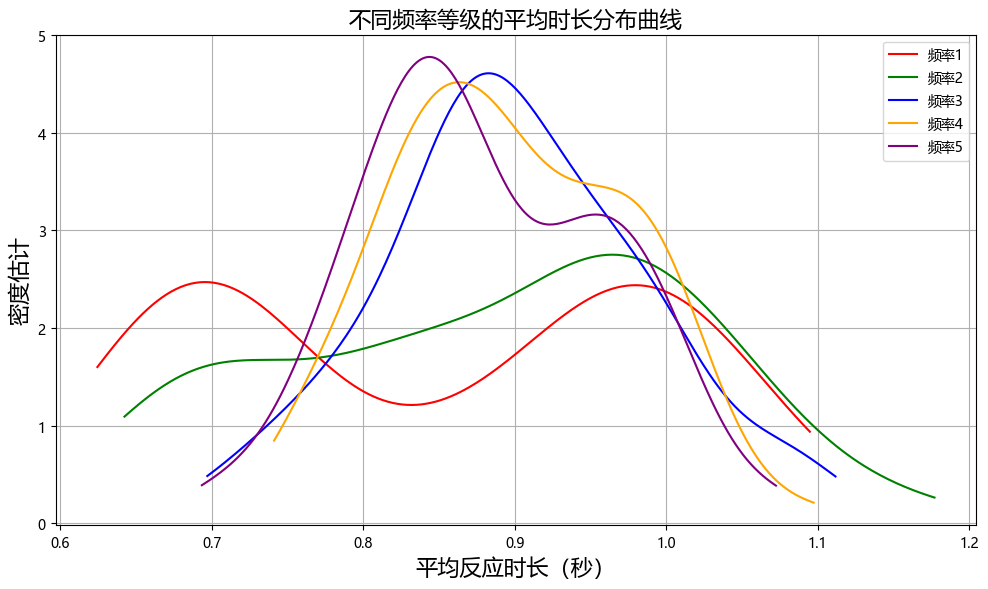

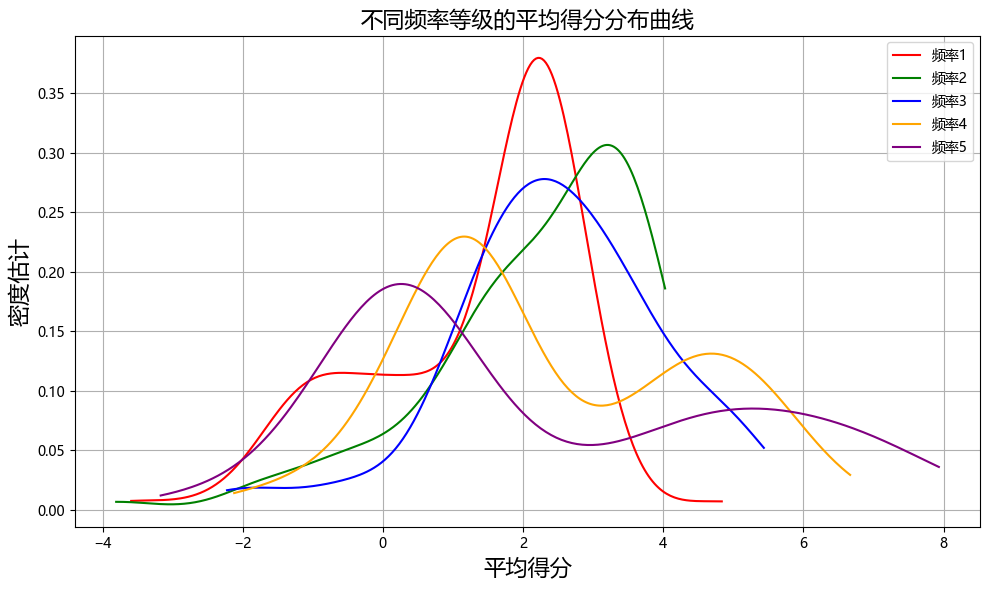

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 读取分析结果
df = pd.read_excel('词语分析结果.xlsx')

# 准备颜色和标签
colors = ['r', 'g', 'b', 'orange', 'purple']
labels = ['频率1', '频率2', '频率3', '频率4', '频率5']

# =============================
# 🎯 1. 绘制平均时长分布曲线
# =============================
plt.figure(figsize=(10, 6))

for level, color, label in zip(range(1, 6), colors, labels):
    subset = df[df['频率'] == level]['平均时长']
    if len(subset) < 2:  # 避免样本太少无法估计密度
        continue
    density = gaussian_kde(subset)
    x_vals = np.linspace(subset.min(), subset.max(), 300)
    plt.plot(x_vals, density(x_vals), color=color, label=label)

plt.title('不同频率等级的平均时长分布曲线', fontsize=16)
plt.xlabel('平均反应时长（秒）', fontsize=16)
plt.ylabel('密度估计', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================
# 🎯 2. 绘制平均得分分布曲线
# =============================
plt.figure(figsize=(10, 6))

for level, color, label in zip(range(1, 6), colors, labels):
    subset = df[df['频率'] == level]['平均得分']
    if len(subset) < 2:
        continue
    density = gaussian_kde(subset)
    x_vals = np.linspace(subset.min(), subset.max(), 300)
    plt.plot(x_vals, density(x_vals), color=color, label=label)

plt.title('不同频率等级的平均得分分布曲线', fontsize=16)
plt.xlabel('平均得分', fontsize=16)
plt.ylabel('密度估计', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
cache_path = "bert_vector_cache.pkl"
# 提取 BERT 向量的函数（带 GPU 和缓存）
with open(cache_path, 'rb') as f:
    vector_cache = pickle.load(f)
print(f"✅ 成功加载缓存，共有 {len(vector_cache)} 条记录")

def get_bert_vector(word):
    if word in vector_cache:
        return vector_cache[word]
    
    inputs = tokenizer(word, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_vector = outputs.last_hidden_state[0, 0].cpu().numpy()
    
    vector_cache[word] = cls_vector
    return cls_vector
# 收集数据
words = []
labels = []
vectors = []

for word, entry in word_data.items():
    vec = get_bert_vector(word)
    vectors.append(vec)
    words.append(word)
    labels.append(1 if entry['is_true_word'] == 'True' else 0)

# 保存缓存
with open(cache_path, 'wb') as f:
    pickle.dump(vector_cache, f)
    print(f"✅ 向量缓存已保存到：{cache_path}")

# 转换为数组
X = np.array(vectors)
y = np.array(labels)

# 聚类
kmeans = KMeans(n_clusters=8, random_state=0)
cluster_labels = kmeans.fit_predict(X)
sil_score = silhouette_score(X, cluster_labels)
print(f"✅ 聚类轮廓系数：{sil_score:.4f}")

# 输出结果到 CSV
output_records = []

for word, label, cluster, vec in zip(words, labels, cluster_labels, vectors):
    record = {
        '词语': word,
        '标签（是否真词）': label,
        '聚类类别': cluster
    }
    # 添加向量维度
    for i, v in enumerate(vec):
        record[f'vec_{i}'] = v
    output_records.append(record)

df = pd.DataFrame(output_records)
csv_path = "bert_vectors_cluster.csv"
df.to_csv(csv_path, index=False, encoding='utf-8-sig')
print(f"✅ 结果已保存为 CSV 文件：{csv_path}")

✅ 成功加载缓存，共有 499 条记录
✅ 向量缓存已保存到：bert_vector_cache.pkl


e:\Python Environment\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


✅ 聚类轮廓系数：0.1102
✅ 结果已保存为 CSV 文件：bert_vectors_cluster.csv


In [21]:
import os
import torch
import pickle
import math
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
# 设置设备（GPU 优先）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ 使用设备：{device}")

# 缓存路径
cache_path = "bert_vector_cache.pkl"

# 加载模型和 tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model = BertModel.from_pretrained("bert-base-chinese").to(device)
model.eval()

# 加载缓存（如果存在）
if os.path.exists(cache_path):
    with open(cache_path, 'rb') as f:
        vector_cache = pickle.load(f)
    print(f"✅ 成功加载缓存，共有 {len(vector_cache)} 条记录")
else:
    vector_cache = {}

# 提取 BERT 向量的函数（带 GPU 和缓存）
def get_bert_vector(word):
    if word in vector_cache:
        return vector_cache[word]
    
    inputs = tokenizer(word, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_vector = outputs.last_hidden_state[0, 0].cpu().numpy()
    
    vector_cache[word] = cls_vector
    return cls_vector

def compute_entropy_score(cluster_labels, true_labels):
    total_score = 0.0
    N = len(cluster_labels)
    n_clusters = np.max(cluster_labels) + 1
    for cluster_id in range(n_clusters):
        indices = np.where(cluster_labels == cluster_id)[0]
        ni = len(indices)
        if ni == 0:
            continue
        true_count = np.sum(true_labels[indices])
        pi = true_count / ni
        if pi == 0 or pi == 1:
            entropy = 0
        else:
            entropy = -pi * math.log2(pi) - (1 - pi) * math.log2(1 - pi)
        total_score += (ni / N) * entropy
    return total_score

# λ搜索范围（例如从 0 到 0.02，间隔0.001）
lambda_list = np.arange(0, 0.021, 0.001)
best_ks = []
best_scores = []

print("📊 正在进行 λ 网格搜索...")

for lam in lambda_list:
    min_score = float('inf')
    best_k = None

    for k in range(2, 101):
        kmeans_k = KMeans(n_clusters=k, random_state=0).fit(X)
        cluster_labels_k = kmeans_k.labels_
        entropy_score = compute_entropy_score(cluster_labels_k, y)
        total_score = entropy_score + lam * k

        if total_score < min_score:
            min_score = total_score
            best_k = k

    best_ks.append(best_k)
    best_scores.append(min_score)
    print(f"λ={lam:.3f} 👉 最佳K={best_k}, Score={min_score:.4f}")

✅ 使用设备：cuda
✅ 成功加载缓存，共有 499 条记录
📊 正在进行 λ 网格搜索...
λ=0.000 👉 最佳K=96, Score=0.4951
λ=0.001 👉 最佳K=31, Score=0.5669
λ=0.002 👉 最佳K=30, Score=0.5973
λ=0.003 👉 最佳K=30, Score=0.6273
λ=0.004 👉 最佳K=30, Score=0.6573
λ=0.005 👉 最佳K=30, Score=0.6873
λ=0.006 👉 最佳K=8, Score=0.7033
λ=0.007 👉 最佳K=8, Score=0.7113
λ=0.008 👉 最佳K=8, Score=0.7193
λ=0.009 👉 最佳K=8, Score=0.7273
λ=0.010 👉 最佳K=8, Score=0.7353
λ=0.011 👉 最佳K=8, Score=0.7433
λ=0.012 👉 最佳K=8, Score=0.7513
λ=0.013 👉 最佳K=8, Score=0.7593
λ=0.014 👉 最佳K=8, Score=0.7673
λ=0.015 👉 最佳K=8, Score=0.7753
λ=0.016 👉 最佳K=8, Score=0.7833
λ=0.017 👉 最佳K=8, Score=0.7913
λ=0.018 👉 最佳K=8, Score=0.7993
λ=0.019 👉 最佳K=8, Score=0.8073
λ=0.020 👉 最佳K=5, Score=0.8132


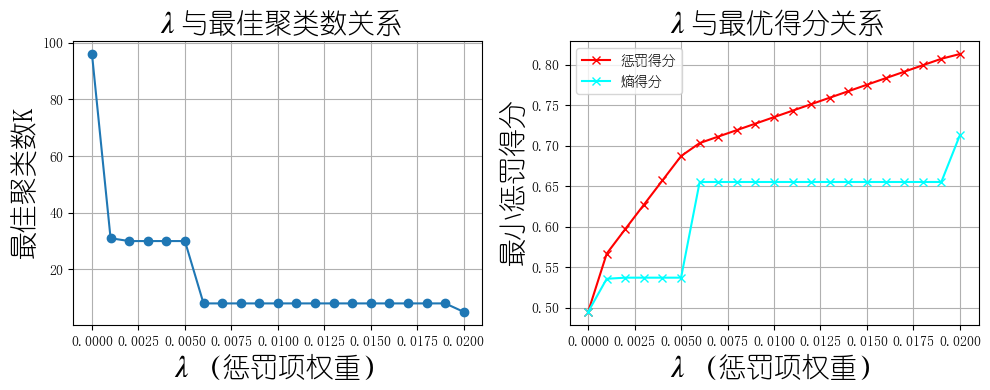

In [22]:
# 绘制 λ vs 最佳K 曲线
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(lambda_list, best_ks, marker='o')
plt.xlabel('λ（惩罚项权重）', fontsize=20)
plt.ylabel('最佳聚类数K', fontsize=20)
plt.title('λ与最佳聚类数关系', fontsize=20)
plt.grid(True)
best_scores_entropy = best_scores - np.linspace(0.000, 0.020, 21) * best_ks
# 绘制 λ vs 最佳Score曲线
plt.subplot(1, 2, 2)
plt.plot(lambda_list, best_scores, marker='x', color='red', label='惩罚得分')
plt.plot(lambda_list, best_scores_entropy, marker='x', color='cyan', label='熵得分')
plt.legend()
plt.xlabel('λ（惩罚项权重）', fontsize=20)
plt.ylabel('最小惩罚得分', fontsize=20)
plt.title('λ与最优得分关系', fontsize=20)
plt.grid(True)

plt.tight_layout()
plt.show()


✅ 达到 80% 方差贡献度所需的维度数：75


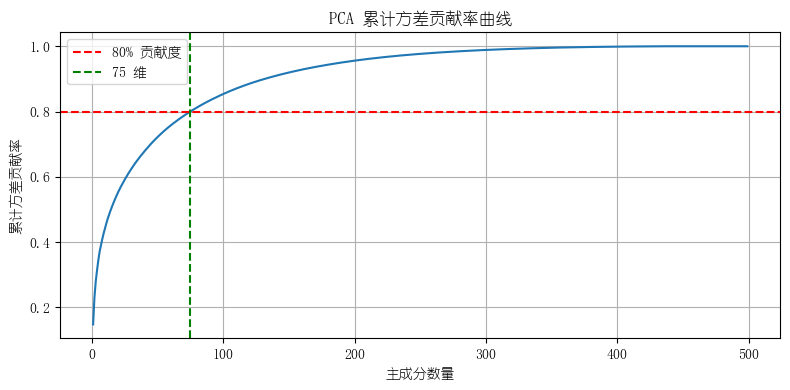

✅ 原始维度：768，压缩后维度：75


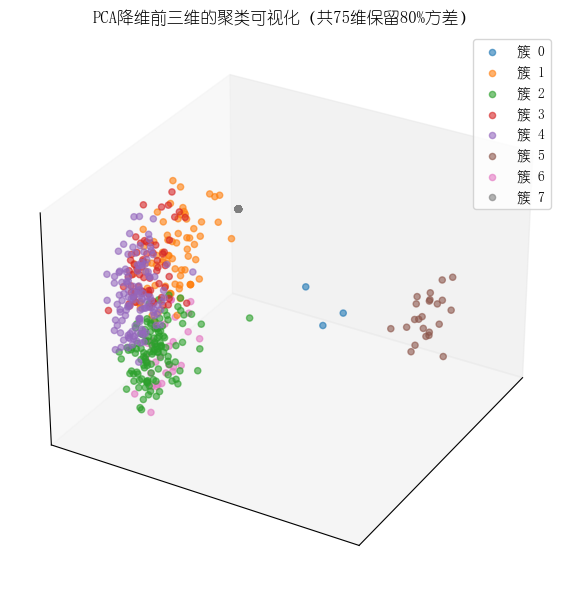

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 拟合 PCA 模型（不设降维目标，先取全部）
pca_full = PCA()
pca_full.fit(X)

# 获取每个主成分的方差贡献率
explained_variance_ratio = pca_full.explained_variance_ratio_

# 计算累计贡献率
cumulative_variance = np.cumsum(explained_variance_ratio)

# 找到使累计贡献度 >= 85% 的最小维度数
target_dimension = np.argmax(cumulative_variance >= 0.80) + 1
print(f"✅ 达到 80% 方差贡献度所需的维度数：{target_dimension}")

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(cumulative_variance)+1), cumulative_variance)
plt.axhline(0.80, color='r', linestyle='--', label='80% 贡献度')
plt.axvline(target_dimension, color='g', linestyle='--', label=f'{target_dimension} 维')
plt.xlabel('主成分数量')
plt.ylabel('累计方差贡献率')
plt.title('PCA 累计方差贡献率曲线')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 重新使用 target_dimension 做降维
pca = PCA(n_components=target_dimension)
X_reduced = pca.fit_transform(X)
print(f"✅ 原始维度：{X.shape[1]}，压缩后维度：{X_reduced.shape[1]}")
# 取前3个主成分
X_vis_3d = X_reduced[:, :3]
# 创建 3D 图像
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制每个簇的散点
for cluster_id in np.unique(cluster_labels):
    indices = np.where(cluster_labels == cluster_id)[0]
    ax.scatter(
        X_vis_3d[indices, 0], 
        X_vis_3d[indices, 1], 
        X_vis_3d[indices, 2],
        label=f'簇 {cluster_id}',
        alpha=0.6
    )
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# 设置图标题和坐标轴标签
ax.set_title(f'PCA降维前三维的聚类可视化（共{target_dimension}维保留80%方差）')
ax.zaxis._axinfo['juggled'] = (1,2,0)
ax.legend()
plt.tight_layout()
plt.show()


e:\Python Environment\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\dell\AppData\Local\Temp\ipykernel_29944\3839976205.py:22: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) YouYuan.
  plt.tight_layout()
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) YouYuan.
  fig.canvas.print_figure(bytes_io, **kw)


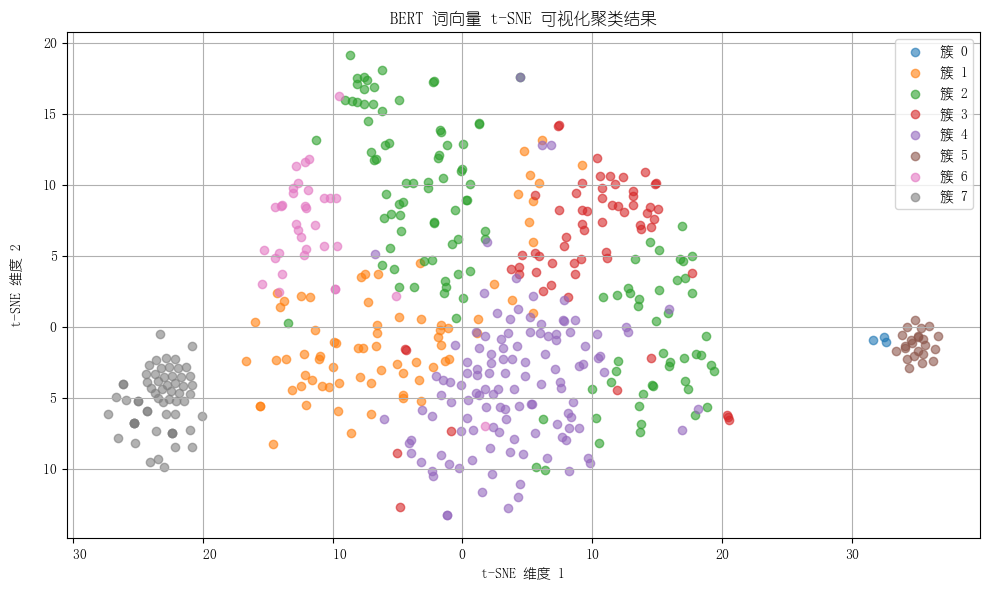

In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 使用 t-SNE 进行 2D 降维
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_reduced)  # X 是原始或PCA压缩后的高维向量

# 可视化聚类结果
plt.figure(figsize=(10, 6))

# 为每个聚类簇上色
for cluster_id in np.unique(cluster_labels):
    indices = np.where(cluster_labels == cluster_id)[0]
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f'簇 {cluster_id}', alpha=0.6)

plt.title('BERT 词向量 t-SNE 可视化聚类结果')
plt.xlabel('t-SNE 维度 1')
plt.ylabel('t-SNE 维度 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


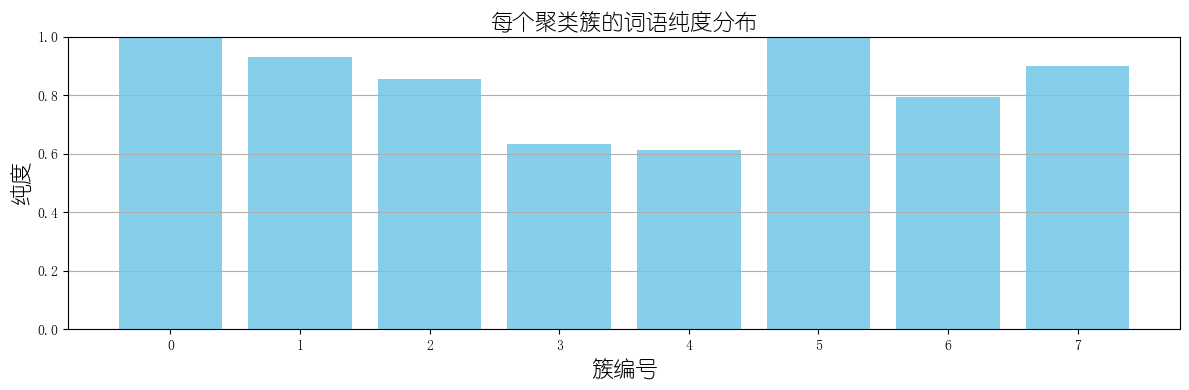

余弦相似度分类准确率:0.7896


In [25]:
def plot_cluster_purity(cluster_labels, true_labels):
    n_clusters = np.max(cluster_labels) + 1
    purity = []
    sizes = []

    for cluster_id in range(n_clusters):
        indices = np.where(cluster_labels == cluster_id)[0]
        ni = len(indices)
        if ni == 0:
            purity.append(1)
            sizes.append(0)
            continue
        true_count = np.sum(true_labels[indices])
        pi = true_count / ni
        purity.append(max(pi, 1-pi))
        sizes.append(ni)

    # 绘制柱状图
    plt.figure(figsize=(12, 4))
    plt.bar(range(n_clusters), purity, color='skyblue')
    plt.xlabel('簇编号', fontsize=16)
    plt.ylabel('纯度', fontsize=16)
    plt.title('每个聚类簇的词语纯度分布', fontsize=16)
    plt.ylim(0, 1)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    print("余弦相似度分类准确率:{:.4f}".format(np.sum(np.array(purity) * np.array(sizes))/np.sum(np.array(sizes))))

plot_cluster_purity(cluster_labels, y)

✅ 加惩罚后的最佳聚类数为：30，得分：0.6873


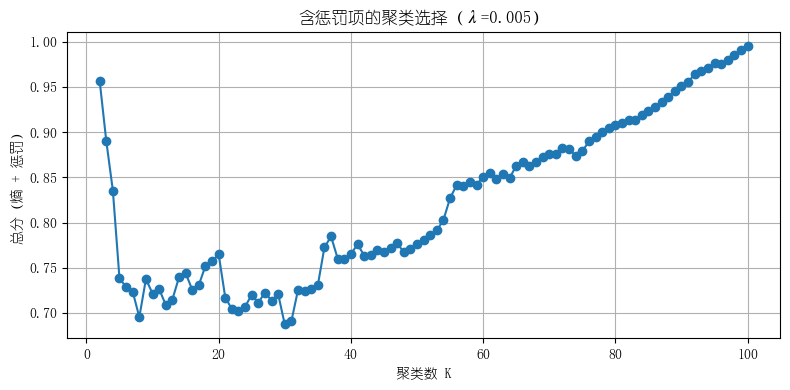

In [26]:
lambda_penalty = 0.005  # 可调参数，建议尝试 0.001~0.02 之间的值

best_k = 2
min_score = float('inf')
scores = []

for k in range(2, 101):
    kmeans_k = KMeans(n_clusters=k, random_state=0).fit(X)
    cluster_labels_k = kmeans_k.labels_
    entropy_score = compute_entropy_score(cluster_labels_k, y)
    
    total_score = entropy_score + lambda_penalty * k
    scores.append((k, total_score))

    if total_score < min_score:
        min_score = total_score
        best_k = k

print(f"✅ 加惩罚后的最佳聚类数为：{best_k}，得分：{min_score:.4f}")
ks, score_vals = zip(*scores)
plt.figure(figsize=(8, 4))
plt.plot(ks, score_vals, marker='o')
plt.xlabel('聚类数 K')
plt.ylabel('总分（熵 + 惩罚）')
plt.title(f'含惩罚项的聚类选择（λ={lambda_penalty}）')
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# 让结果可复现（可选）
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
words = []
labels = []
for w, entry in word_data.items():
    # 将 is_true_word 映射为二分类标签：True=1, False=0
    label = 1 if entry['is_true_word'].lower() == 'true' else 0
    words.append(w)
    labels.append(label)

print(f"共有样本数: {len(words)}")

共有样本数: 499


In [28]:
class WordDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=32):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),         # shape: (max_len)
            'attention_mask': encoding['attention_mask'].squeeze(0),# shape: (max_len)
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 初始化分词器
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

# 构建数据集
full_dataset = WordDataset(words, labels, tokenizer, max_len=32)

# 例如：按 8:2 划分训练集和验证集
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
print(f"训练集: {len(train_dataset)} 条, 验证集: {len(val_dataset)} 条.")

# 构建 DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


训练集: 399 条, 验证集: 100 条.


In [29]:
# 使用设备（CPU/GPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"当前使用设备: {device}")

# 初始化 BertForSequenceClassification (num_labels=2 表示二分类)
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=2)
model.to(device)


当前使用设备: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
model_save_path = "bert_classifier.pt"
pre_trained = False
if os.path.exists(model_save_path) and pre_trained:
    model.load_state_dict(torch.load(model_save_path))
    print(f"✅ 已加载预训练模型：{model_save_path}")
else:
    print("🔁 未找到保存模型，开始新训练。")
# 训练参数
epochs = 25
learning_rate = 1e-5

# AdamW 优化器
optimizer = AdamW(model.parameters(), lr=learning_rate)

# 总训练步骤
total_steps = len(train_loader) * epochs

# 学习率调度器：线性下降 + warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 预热10%
    num_training_steps=total_steps
)
train_loss = []
val_loss = []
acc = []
for epoch in range(epochs):
    # ====== 训练模式 ======
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        # 取数据并放到 GPU/CPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 前向 + 计算loss
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # ====== 验证模式 ======
    model.eval()
    total_eval_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits  # shape: (batch_size, 2)

            total_eval_loss += loss.item()

            # 计算准确率
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_eval_loss / len(val_loader)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    train_loss.append(avg_train_loss)
    val_loss.append(avg_val_loss)
    acc.append(val_acc)
torch.save(model.state_dict(), model_save_path)
print(f"✅ 模型已保存至：{model_save_path}")


🔁 未找到保存模型，开始新训练。
Epoch 1/25 | Train Loss: 0.7063 | Val Loss: 0.6569 | Val Acc: 0.5800
Epoch 2/25 | Train Loss: 0.6617 | Val Loss: 0.5818 | Val Acc: 0.8200
Epoch 3/25 | Train Loss: 0.5806 | Val Loss: 0.5201 | Val Acc: 0.8100
Epoch 4/25 | Train Loss: 0.4900 | Val Loss: 0.4675 | Val Acc: 0.8000
Epoch 5/25 | Train Loss: 0.3937 | Val Loss: 0.4248 | Val Acc: 0.8300
Epoch 6/25 | Train Loss: 0.3211 | Val Loss: 0.4190 | Val Acc: 0.8400
Epoch 7/25 | Train Loss: 0.2738 | Val Loss: 0.4236 | Val Acc: 0.8400
Epoch 8/25 | Train Loss: 0.2271 | Val Loss: 0.4491 | Val Acc: 0.8300
Epoch 9/25 | Train Loss: 0.2115 | Val Loss: 0.4241 | Val Acc: 0.8600
Epoch 10/25 | Train Loss: 0.1647 | Val Loss: 0.4187 | Val Acc: 0.8700
Epoch 11/25 | Train Loss: 0.1468 | Val Loss: 0.4275 | Val Acc: 0.8700
Epoch 12/25 | Train Loss: 0.1110 | Val Loss: 0.4491 | Val Acc: 0.8400
Epoch 13/25 | Train Loss: 0.1278 | Val Loss: 0.4593 | Val Acc: 0.8400
Epoch 14/25 | Train Loss: 0.1067 | Val Loss: 0.4455 | Val Acc: 0.8500
Epoch 15/25 

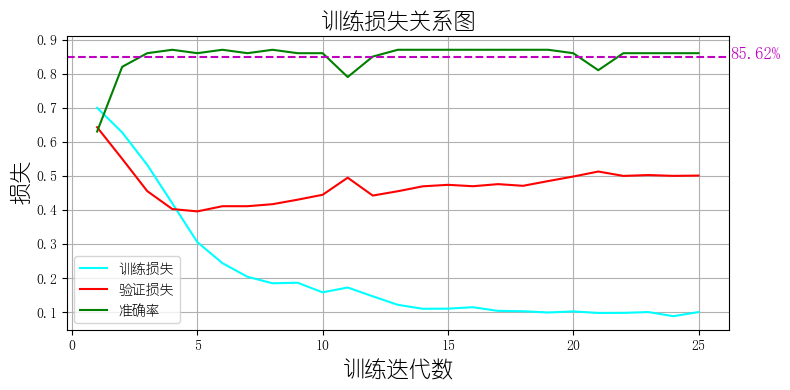

In [ ]:
train_history = np.linspace(1,epochs,epochs)
plt.figure(figsize=(8, 4))
plt.plot(train_history, train_loss, color='cyan', label='训练损失')
plt.plot(train_history, val_loss, color='red', label='验证损失')
plt.plot(train_history, acc, color='green', label='准确率')
plt.axhline(np.mean(acc), color = 'm', linestyle = '--')
plt.text(x=max(train_history)*1.05, y=np.mean(acc[9:]), s=f'{100*np.mean(acc[9:]):.2f}%', color='m', fontsize=12, va='center')
plt.xlabel('训练迭代数', fontsize=16)
plt.ylabel('损失', fontsize=16)
plt.title('训练损失关系图', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\dell\AppData\Local\Temp\ipykernel_29944\837497429.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


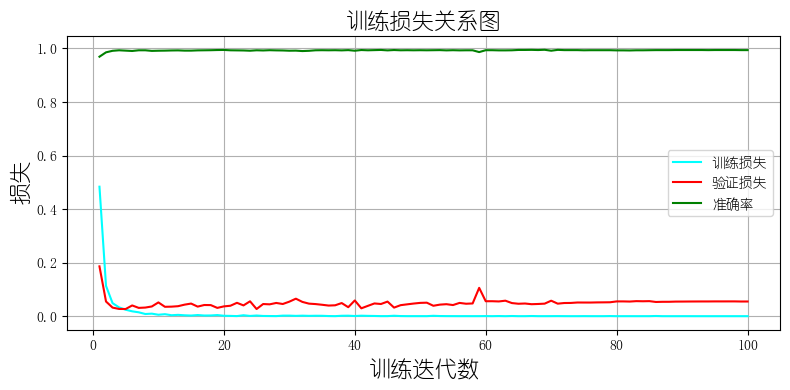

In [30]:
# 读取文件
model_save_path = "./train/25bert_classifier.pt"
model.load_state_dict(torch.load(model_save_path))
remote_log = pd.read_excel("训练过程记录.xlsx")

# 赋值变量（第2、3、4列）
x_axis = remote_log.iloc[:, 0].tolist()
train_loss = remote_log.iloc[:, 1].tolist()  # 第二列：Train Loss
val_loss = remote_log.iloc[:, 2].tolist()    # 第三列：Validation Loss
val_acc = remote_log.iloc[:, 3].tolist()     # 第四列：Validation Accuracy

plt.figure(figsize=(8, 4))
plt.plot(x_axis, train_loss, color='cyan', label='训练损失')
plt.plot(x_axis, val_loss, color='red', label='验证损失')
plt.plot(x_axis, val_acc, color='green', label='准确率')
# plt.axhline(np.mean(val_acc), color = 'm', linestyle = '--')
# plt.text(x=max(train_history)*1.05, y=np.mean(acc[9:]), s=f'{100*np.mean(acc[9:]):.2f}%', color='m', fontsize=12, va='center')
plt.xlabel('训练迭代数', fontsize=16)
plt.ylabel('损失', fontsize=16)
plt.title('训练损失关系图', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
def predict_word(model, tokenizer, text):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        return_tensors="pt",
        max_length=32,
        truncation=True,
        padding='max_length'
    )
    # 将输入放置到同一设备
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred_label = torch.argmax(logits, dim=1).item()
    # 1 -> True, 0 -> False
    return "True" if pred_label == 1 else "False"

pred_result = []
for word in words:
    pred = predict_word(model, tokenizer, word)
    pred_result.append(1 if pred == 'True' else 0)

# 转换为 numpy 数组以便比较
pred_result = np.array(pred_result)
labels = np.array([1 if word_data[word]['is_true_word'] == 'True' else 0 for word in words])

# 计算准确率
accuracy = np.sum(pred_result == labels) / len(labels)
print("预测准确率：{:.4f}".format(accuracy))
# 写入 Excel 文件
# 构造 DataFrame（每一行为一个样本）
df = pd.DataFrame(
    list(zip(words, labels, pred_result)),
    columns=['词语', '真实标签', '预测标签']
)
output_path = os.path.join(os.getcwd(), 'Bert预测结果.xlsx')
df.to_excel(output_path, index=False)
print(f"✅ 分析结果已保存到：{output_path}")

# === 计算混淆矩阵 ===
TP = np.sum((labels == 1) & (pred_result == 1))
FP = np.sum((labels == 0) & (pred_result == 1))
TN = np.sum((labels == 0) & (pred_result == 0))
FN = np.sum((labels == 1) & (pred_result == 0))

print("\n📊 混淆矩阵（模型预测）:")
print(f"TP（真词预测为真）: {TP*0.14:.4f}")
print(f"FP（假词预测为真）: {FP*0.14:.4f}")
print(f"TN（假词预测为假）: {TN*0.14:.4f}")
print(f"FN（真词预测为假）: {FN*0.14:.4f}")

# 其他指标（可选）
precision = TP / (TP + FP) if TP + FP > 0 else 0
recall    = TP / (TP + FN) if TP + FN > 0 else 0
f1_score  = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
accuracy  = (TP + TN) / (TP + FP + TN + FN)

print("\n🎯 指标:")
print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"F1 分数: {f1_score:.4f}")


预测准确率：0.8737
✅ 分析结果已保存到：f:\江南大学本科\自然语言处理\Bert预测结果.xlsx

📊 混淆矩阵（模型预测）:
TP（真词预测为真）: 29.9600
FP（假词预测为真）: 3.3600
TN（假词预测为假）: 31.0800
FN（真词预测为假）: 5.4600

🎯 指标:
准确率 (Accuracy): 0.8737
精确率 (Precision): 0.8992
召回率 (Recall): 0.8458
F1 分数: 0.8717


In [42]:
from collections import defaultdict

# 初始化分组结构
freq_stats = defaultdict(lambda: {"TP": 0, "FP": 0, "TN": 0, "FN": 0})

# 遍历所有词语，按频率等级分别统计
for word, true_label, pred_label in zip(words, labels, pred_result):
    freq = word_data[word]['freq_level']  # 频率等级：1~5
    if true_label == 1 and pred_label == 1:
        freq_stats[freq]["TP"] += 1
    elif true_label == 0 and pred_label == 1:
        freq_stats[freq]["FP"] += 1
    elif true_label == 0 and pred_label == 0:
        freq_stats[freq]["TN"] += 1
    elif true_label == 1 and pred_label == 0:
        freq_stats[freq]["FN"] += 1

# 输出每一频率等级的结果
print("\n📊 按频率等级统计：")
for freq in sorted(freq_stats.keys()):
    stats = freq_stats[freq]
    TP = stats["TP"]
    FP = stats["FP"]
    TN = stats["TN"]
    FN = stats["FN"]

    total = TP + FP + TN + FN
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    acc = (TP + TN) / total if total > 0 else 0

    print(f"\n🔹 频率等级 {freq}:")
    print(f"TP={TP*0.14:.4f} | FP={FP*0.14:.4f} | TN={TN*0.14:.4f} | FN={FN*0.14:.4f}")
    print(f"准确率: {acc:.4f}")
    print(f"查准率: {precision:.4f}")
    print(f"查全率: {recall:.4f}")
    print(f"F1 分数: {f1:.4f}")



📊 按频率等级统计：

🔹 频率等级 1:
TP=6.8600 | FP=2.3800 | TN=4.6200 | FN=0.0000
准确率: 0.8283
查准率: 0.7424
查全率: 1.0000
F1 分数: 0.8522

🔹 频率等级 2:
TP=6.7200 | FP=0.8400 | TN=6.1600 | FN=0.2800
准确率: 0.9200
查准率: 0.8889
查全率: 0.9600
F1 分数: 0.9231

🔹 频率等级 3:
TP=5.8800 | FP=0.1400 | TN=6.5800 | FN=1.2600
准确率: 0.8990
查准率: 0.9767
查全率: 0.8235
F1 分数: 0.8936

🔹 频率等级 4:
TP=5.6000 | FP=0.0000 | TN=6.8600 | FN=1.5400
准确率: 0.8900
查准率: 1.0000
查全率: 0.7843
F1 分数: 0.8791

🔹 频率等级 5:
TP=4.9000 | FP=0.0000 | TN=6.8600 | FN=2.3800
准确率: 0.8317
查准率: 1.0000
查全率: 0.6731
F1 分数: 0.8046


In [32]:
import scipy.stats as stats
from collections import defaultdict

# 1. 建立容器，按频率分组，收集各词的(平均时长 / 平均得分 / 正确率)
times_by_level = defaultdict(list)
scores_by_level = defaultdict(list)
acc_by_level   = defaultdict(list)

for word, entry in word_data.items():
    freq_level = entry['freq_level']
    guesses = entry['guesses']
    if not guesses:
        continue

    # ---- 计算该词的平均时长 ----
    times = [g['time'] for g in guesses]
    avg_time = sum(times) / len(times)
    
    # ---- 计算该词的平均得分 ----
    scores = [g['score'] for g in guesses]
    avg_score = sum(scores) / len(scores)

    # ---- 计算该词的正确率 ----
    true_label = entry['is_true_word']
    correct = sum(1 for g in guesses if g['player_guess'] == true_label)
    total   = len(guesses)
    accuracy = correct / total if total > 0 else 0.0

    # ---- 将这些值按词频等级分组存储 ----
    times_by_level[freq_level].append(avg_time)
    scores_by_level[freq_level].append(avg_score)
    acc_by_level[freq_level].append(accuracy)

# 2. 准备对(1~5)各等级做 ANOVA 分析
#   先把每个等级的数据取出来，确保每组都有样本
level_range = [1, 2, 3, 4, 5]
time_groups  = [times_by_level[l] for l in level_range if len(times_by_level[l]) > 0]
score_groups = [scores_by_level[l] for l in level_range if len(scores_by_level[l]) > 0]
acc_groups   = [acc_by_level[l]   for l in level_range if len(acc_by_level[l])   > 0]

# 简单检查一下是否有空组
for l in level_range:
    print(f"频率等级 {l}：时长样本数 = {len(times_by_level[l])}, "
          f"得分样本数 = {len(scores_by_level[l])}, "
          f"正确率样本数 = {len(acc_by_level[l])}")

# 3. 单因素方差分析 (One-way ANOVA)
#    stats.f_oneway(*groups) 需要把每个等级的数据列表拆开传入
#    如果出现组为空、长度过短，可能会报错；实际使用时需做额外处理
if len(time_groups) == 5: 
    F_time, p_time = stats.f_oneway(*time_groups)
    print(f"[时长] F统计量={F_time:.3f}, p值={p_time:.5f}")
    if p_time < 0.05:
        print("=> 不同频率等级的平均时长存在显著差异 (p < 0.05)")
    else:
        print("=> 未发现显著差异 (p >= 0.05)")

if len(score_groups) == 5:
    F_score, p_score = stats.f_oneway(*score_groups)
    print(f"[得分] F统计量={F_score:.3f}, p值={p_score:.5f}")
    if p_score < 0.05:
        print("=> 不同频率等级的平均得分存在显著差异 (p < 0.05)")
    else:
        print("=> 未发现显著差异 (p >= 0.05)")

if len(acc_groups) == 5:
    F_acc, p_acc = stats.f_oneway(*acc_groups)
    print(f"[正确率] F统计量={F_acc:.3f}, p值={p_acc:.5f}")
    if p_acc < 0.05:
        print("=> 不同频率等级的正确率存在显著差异 (p < 0.05)")
    else:
        print("=> 未发现显著差异 (p >= 0.05)")


频率等级 1：时长样本数 = 99, 得分样本数 = 99, 正确率样本数 = 99
频率等级 2：时长样本数 = 100, 得分样本数 = 100, 正确率样本数 = 100
频率等级 3：时长样本数 = 99, 得分样本数 = 99, 正确率样本数 = 99
频率等级 4：时长样本数 = 100, 得分样本数 = 100, 正确率样本数 = 100
频率等级 5：时长样本数 = 101, 得分样本数 = 101, 正确率样本数 = 101
[时长] F统计量=4.076, p值=0.00292
=> 不同频率等级的平均时长存在显著差异 (p < 0.05)
[得分] F统计量=5.775, p值=0.00015
=> 不同频率等级的平均得分存在显著差异 (p < 0.05)
[正确率] F统计量=1.474, p值=0.20872
=> 未发现显著差异 (p >= 0.05)


In [33]:
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 将各等级时长数据展开为一维列表，并记录组标签
time_data = []
time_labels = []
for l in level_range:
    for t in times_by_level[l]:
        time_data.append(t)
        time_labels.append(str(l))  # 用字符串表示当前等级

time_data = np.array(time_data)
time_labels = np.array(time_labels)

# 调用 pairwise_tukeyhsd
tukey_time = pairwise_tukeyhsd(endog=time_data, groups=time_labels, alpha=0.05)
print(tukey_time)

score_data = []
score_labels = []
for l in level_range:
    for s in scores_by_level[l]:
        score_data.append(s)
        score_labels.append(str(l))

score_data = np.array(score_data)
score_labels = np.array(score_labels)

tukey_score = pairwise_tukeyhsd(endog=score_data, groups=score_labels, alpha=0.05)
print(tukey_score)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.0399 0.0793 -0.0028 0.0825  False
     1      3   0.0554 0.0038  0.0127 0.0982   True
     1      4   0.0533  0.006  0.0107  0.096   True
     1      5   0.0365 0.1314  -0.006  0.079  False
     2      3   0.0155 0.8562 -0.0271 0.0582  False
     2      4   0.0135  0.909 -0.0291  0.056  False
     2      5  -0.0034 0.9995 -0.0458  0.039  False
     3      4  -0.0021 0.9999 -0.0447 0.0406  False
     3      5  -0.0189 0.7404 -0.0615 0.0236  False
     4      5  -0.0169  0.813 -0.0593 0.0256  False
---------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.9079 0.0088   0.157 1.6588   True
     1      3   1.1637 0.0003  0.4109 1.9165   True
     1      

## 时长 (Time) 事后分析
- group1 group2: 分别是两组词频等级，取值为 [1,2,3,4,5]。
- meandiff: 表示组1均值 - 组2均值 的差值（此处为时长平均值的差）
- p-adj: 经过 Tukey 多重比较校正后的 p 值
- reject: 是否在显著性水平 α=0.05 下拒绝原假设（即是否存在组均值显著差异）
### 主要结论：
- 1 vs 3: meandiff = 0.0554, p=0.0038, reject=True
- 说明词频等级 1 与 3 在“平均时长”上存在显著差异，并且 group1 > group2（因为差值为正）。
- 即等级 1 的时长显著高于等级 3。
- 1 vs 4: meandiff = 0.0533, p=0.006, reject=True
- 同理，等级 1 的时长显著高于等级 4。
- 其余对比均为 reject=False
- 如 1 vs 2、1 vs 5 等不显著，说明 1 与 2、5 的差异不明显；2, 3, 4, 5 之间互相也没有显著差别。
### 直观解释：
- 词频=1 的平均时长明显大于词频=3 和 词频=4；但与 2、5 的差异并不显著。
- 这与前面 ANOVA 的结论一致：整体有显著差异，但主要体现在 1 vs 3、1 vs 4。
## 得分 (Score) 事后分析
- 只有 1 vs 2, 1 vs 3, 1 vs 4, 1 vs 5 均为 reject=True 并且差值为正；其他组对比均为不显著。
### 主要结论：
- 词频=1 与所有其他组 (2,3,4,5) 的得分均值存在显著差异，且 meandiff > 0，说明等级 1 的得分更高。
- 其余各组 (2 vs 3, 2 vs 4, …, 4 vs 5) 不显著，表示 2,3,4,5 间彼此无明显差异。
### 直观解释：
- 词频=1 的平均得分显著高于 2,3,4,5；后四者之间在得分上的差异不大。
- 这可能表明：尽管时长更长，但若仍能正确回答或有更高奖励机制时，低频词（等级 1）反而获取了更高的平均得分（具体原因要结合实验或规则解读）。

C:\Users\dell\AppData\Local\Temp\ipykernel_29944\3554456591.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_time, labels=level_range)


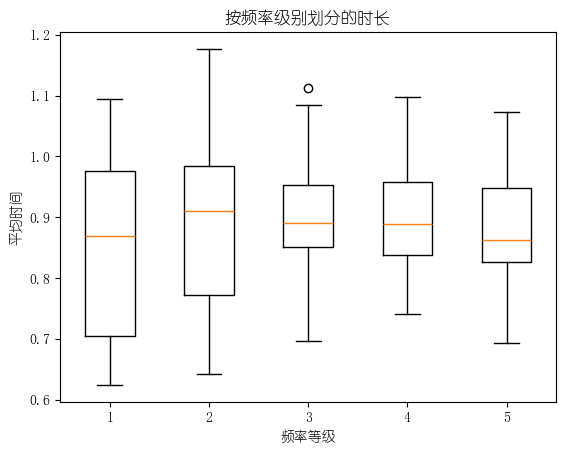

C:\Users\dell\AppData\Local\Temp\ipykernel_29944\3554456591.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_score, labels=level_range)
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) YouYuan.
  fig.canvas.print_figure(bytes_io, **kw)


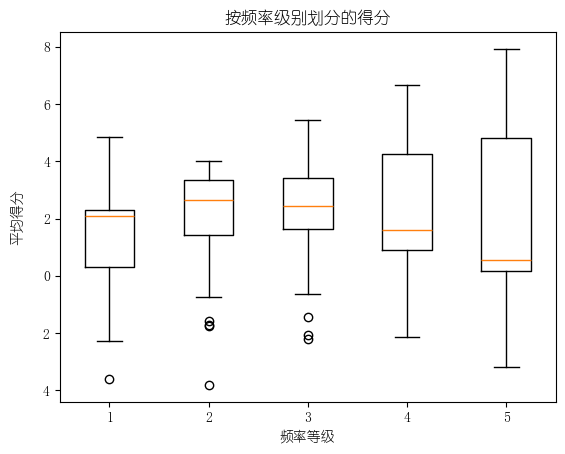

C:\Users\dell\AppData\Local\Temp\ipykernel_29944\3554456591.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_acc, labels=level_range)


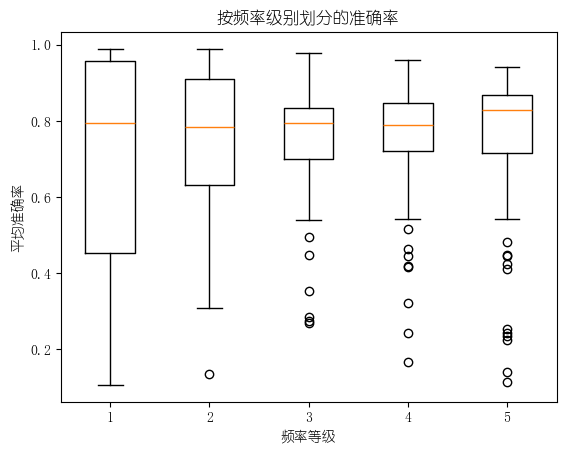

In [34]:
# 1) 绘制“时长”箱线图
boxplot_time = [times_by_level[l] for l in level_range]
plt.boxplot(boxplot_time, labels=level_range)
plt.title("按频率级别划分的时长")
plt.xlabel("频率等级")
plt.ylabel("平均时间")
plt.show()

# 2) 绘制“得分”箱线图
boxplot_score = [scores_by_level[l] for l in level_range]
plt.boxplot(boxplot_score, labels=level_range)
plt.title("按频率级别划分的得分")
plt.xlabel("频率等级")
plt.ylabel("平均得分")
plt.show()

# 3) 绘制“正确率”箱线图
boxplot_acc = [acc_by_level[l] for l in level_range]
plt.boxplot(boxplot_acc, labels=level_range)
plt.title("按频率级别划分的准确率")
plt.xlabel("频率等级")
plt.ylabel("平均准确率")
plt.show()

In [35]:
from scipy.stats import shapiro
print("时长正态分布检测")
for l in level_range:
    w, p = shapiro(times_by_level[l])
    print(f"Level {l}, p={p:.4f}")
    # 如果p<0.05，说明与正态分布差异显著
from scipy.stats import levene
print("时长方差齐性检测")
# 将每组数据分开
time_groups = [times_by_level[l] for l in level_range]
stat, p = levene(*time_groups)
print(f"Levene test p={p:.4f}")
# p>=0.05 => 暗示各组方差无显著差异

print("得分正态分布检测")
for l in level_range:
    w, p = shapiro(scores_by_level[l])
    print(f"Level {l}, p={p:.4f}")
    # 如果p<0.05，说明与正态分布差异显著
print("得分方差齐性检测")
# 将每组数据分开
score_groups = [scores_by_level[l] for l in level_range]
stat, p = levene(*score_groups)
print(f"Levene test p={p:.4f}")

print("准确率正态分布检测")
for l in level_range:
    w, p = shapiro(acc_by_level[l])
    print(f"Level {l}, p={p:.4f}")
    # 如果p<0.05，说明与正态分布差异显著
print("准确率方差齐性检测")
# 将每组数据分开
acc_groups = [acc_by_level[l] for l in level_range]
stat, p = levene(*acc_groups)
print(f"Levene test p={p:.4f}")

时长正态分布检测
Level 1, p=0.0000
Level 2, p=0.0053
Level 3, p=0.6968
Level 4, p=0.2116
Level 5, p=0.1240
时长方差齐性检测
Levene test p=0.0000
得分正态分布检测
Level 1, p=0.0000
Level 2, p=0.0000
Level 3, p=0.0178
Level 4, p=0.0001
Level 5, p=0.0000
得分方差齐性检测
Levene test p=0.0000
准确率正态分布检测
Level 1, p=0.0000
Level 2, p=0.0001
Level 3, p=0.0000
Level 4, p=0.0000
Level 5, p=0.0000
准确率方差齐性检测
Levene test p=0.0000


以下是对上述正态性及方差齐性检验结果的**综合解读**，并给出后续分析的**可行方案**。

---

## 1. 检验结果汇总

根据输出：

1. **时长 (Time)**  
   - **正态检验**(Shapiro-Wilk)：  
     - 频率等级 1 → \(p=0.0000 < 0.05\)，显著偏离正态  
     - 频率等级 2 → \(p=0.0053 < 0.05\)，也显著偏离正态  
     - 频率等级 3 → \(p=0.6968\)，满足正态  
     - 频率等级 4 → \(p=0.2116\)，满足正态  
     - 频率等级 5 → \(p=0.1240\)，满足正态  
     - 小结：**整体不满足完全正态**，特别是 1、2 两组不满足。  
   - **方差齐性**(Levene)：\(p=0.0000 < 0.05\)，说明组间方差显著不齐。

2. **得分 (Score)**  
   - **正态检验**：  
     - 5 个频率等级的 p 值均 < 0.05（0.0000、0.0000、0.0178、0.0001、0.0000），完全不满足正态。  
   - **方差齐性**：\(p=0.0000 < 0.05\)，显著不齐。

3. **准确率 (Accuracy)**  
   - **正态检验**：  
     - 5 个等级全都 p<0.05（0.0000、0.0001、0.0000、0.0000、0.0000），完全不满足正态。  
   - **方差齐性**：\(p=0.0000 < 0.05\)，显著不齐。

### 总体结论

- **三大指标**（时长、得分、正确率）的**各组数据均存在方差不齐**（Levene p=0.0000）。  
- 在正态性上： 
  - **时长**：3、4、5 组相对符合正态，1、2 不符合；整体仍破坏了 ANOVA 要求的“各组近似正态”。  
  - **得分**、**准确率**：所有组均不符合正态。

因此，使用**经典单因素 ANOVA**（及其 Tukey 事后分析）时，它在理论假设上不被满足，可能导致不可靠或带有偏差的结果。

---

## 2. 如何应对这些违反假设的情况

### 2.1 非参数检验：Kruskal-Wallis + Dunn 事后分析

- **Kruskal-Wallis** 是单因素 ANOVA 的非参数替代检验。它只需要假设组间数据独立，对分布形态要求更宽松（不要求正态、方差齐性）。  
- 如果 Kruskal-Wallis 得到显著结果，可再用 **Dunn’s test**（或其他方法）进行两两对比，并配合多重比较修正（如 Bonferroni 或 FDR）。
- 对于**时长、得分、准确率**都可以各自做一遍 Kruskal-Wallis，看看是否得到与原先 ANOVA 类似或不同的结论。

### 2.2 Welch’s ANOVA（可部分应对方差不齐）

- 如果你主要担心**方差不齐**，可以改用 **Welch’s ANOVA** 代替传统 ANOVA。  
- 但同样地，Welch’s ANOVA 仍希望数据分布不至过度偏离正态。若组内严重非正态，仍可能产生偏差。

### 2.3 数据变换（Transformation）

- 若数据分布是典型的**右偏/长尾**（如反应时、分数），可以尝试**对数变换**或**平方根变换**，再重新进行 Shapiro-Wilk、Levene 等检验，看变换后是否变得更符合正态并达到方差齐性。  
- 如果变换后依然不理想，则再次回到 **非参数检验**。

---

## 3. 独立性问题

- 这些检验都默认**各组内、各组间的数据点相互独立**。  
- 如果同一个“词”在不同条件下重复出现，或者同一个玩家多次答题导致数据相关性增加，就可能破坏独立性；需要更复杂的实验设计或混合效应模型。  
- 如果在当前设计下，每个词只出现一次，或对每个词只记录一个平均值，那就能视作近似满足独立性。
